In [1]:
# Imports and environment setup
import os,sys,importlib,gc,pickle
import cartopy.io.shapereader as shapereader
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon
from shapely.ops import cascaded_union

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import cartopy
import cartopy.crs as ccrs

import xarray as xr
import numpy as np

import pandas as pd

os.chdir('/Users/peterpfleiderer/Projects/tropical_cyclones/tc_emulator/results/')

label='ibtracks'

In [2]:
shapes=list(shapereader.Reader('/Users/peterpfleiderer/Projects/data/shapefiles/world/ne_50m_admin_0_countries.shp').records())

islands = []
for item in shapes:
	shape,region=item.geometry,item.attributes
	if region['adm0_a3'] not in ['','-99']:
		if region['subregion']=='Caribbean':
			try:
				islands.append(MultiPolygon(shape))
			except:
				islands.append(Polygon(shape))

islands = list(cascaded_union(islands))

/Users/peterpfleiderer/miniconda2/envs/py_tcs/lib/python3.7/site-packages/ipykernel_launcher.py:98: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


/Users/peterpfleiderer/miniconda2/envs/py_tcs/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


{'label': 0, 'color': 'cyan', 'polygon': [[-61, 32], [-61, 7], [-1, 7], [-1, 32], [-61, 32]]}
{'label': 1, 'color': 'g', 'polygon': [[-61, 7], [-77, 7], [-92, 13], [-92, 20], [-81, 23], [-71, 19], [-64, 18], [-61, 16], [-61, 7]]}
{'label': 2, 'color': 'b', 'polygon': [[-61, 32], [-94, 32], [-92, 20], [-81, 23], [-71, 19], [-64, 18], [-61, 16], [-61, 32]]}


/Users/peterpfleiderer/miniconda2/envs/py_tcs/lib/python3.7/site-packages/ipykernel_launcher.py:127: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


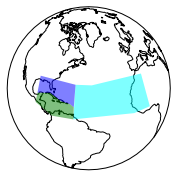

In [3]:
# open an example file to get the time axis
nc_example = xr.open_dataset('/Users/peterpfleiderer/Projects/data/ERA5/ERA5_vws_1979-2018_daily_noTC3.nc')

# Load data
nc_TCs = xr.open_dataset('/Users/peterpfleiderer/Projects/data/IBTrACS.NA.v04r00.nc')
notna1 = (nc_TCs['time'].dt.year >= 1950) & (nc_TCs['time'].dt.year <= 2020)
#notna2 = (nc_TCs['time'].dt.month >= 6) & (nc_TCs['time'].dt.month <= 11)
notna3 = np.isfinite(nc_TCs['wmo_wind']) & (nc_TCs['wmo_wind'] > 0)
#notna4 = nc_TCs['nature'] != 'TS'
reg_atl_path = matplotlib.path.Path([[-98.44,19.48],[-92.29,16.13],[-81.74,8.41],[-74.18,5.62],[-52.21,-0.53],[-9.67,0.35],[-17.4,30.9],[-98.44,36.32],[-98.44,32.25],[-98.44,19.48]])
notna4 = reg_atl_path.contains_points(np.hstack((nc_TCs['lon'].values.flatten()[:,np.newaxis],nc_TCs['lat'].values.flatten()[:,np.newaxis]))).reshape(notna1.shape)

notna = notna1 & notna3 & notna4 #& notna2

tracks_raw = pd.DataFrame()
tracks_raw['lon'] = nc_TCs['lon'].values[notna]
tracks_raw['lat'] = nc_TCs['lat'].values[notna]
tracks_raw['pres'] = nc_TCs['wmo_pres'].values[notna]
tracks_raw['wind'] = nc_TCs['wmo_wind'].values[notna]
tracks_raw['wmo_agency'] = nc_TCs['wmo_agency'].values[notna]
tracks_raw['time'] = nc_TCs['time'].values[notna]
tracks_raw['year'] = [int(str(tt)[:4]) for tt in nc_TCs['time'].values[notna]]
tracks_raw['month'] = [int(str(tt)[5:7]) for tt in nc_TCs['time'].values[notna]]
tracks_raw['day'] = [int(str(tt)[8:10]) for tt in nc_TCs['time'].values[notna]]
tracks_raw['name'] = np.repeat(nc_TCs['name'].values[:,np.newaxis], 360, 1)[notna]
tracks_raw['sid'] = np.repeat(np.array([float(sid.decode("utf-8").replace('N','.')) for sid in nc_TCs['sid'].values])[:,np.newaxis], 360, 1)[notna]

tracks_raw['distance2land'] = nc_TCs['dist2land'].values[notna]
tracks_raw['landfall'] = nc_TCs['landfall'].values[notna]
tracks_raw['storm_dir'] = nc_TCs['storm_dir'].values[notna]
tracks_raw['storm_speed'] = nc_TCs['storm_speed'].values[notna]

genesis = nc_TCs['lon'].copy()
genesis.values[:] = 0
genesis.values[np.unique(np.where(notna)[0]),0] = 1
tracks_raw['genesis'] = genesis.values[notna]

tracks_raw['ACE'] = tracks_raw['wind']** 2 / 10000

# tracks_raw['daily_identifier'] = (tracks_raw['time'] - np.datetime64('1970-01-01')).astype('timedelta64[D]') + np.cumsum(tracks_raw['genesis']) * 10**10
tracks_raw['daily_identifier'] = np.array(np.array([str(tt)[:10] for tt in tracks_raw['time']], np.datetime64) - np.datetime64('1970-01-01'), np.float) + tracks_raw['sid'] * 10**9

tracks = tracks_raw.groupby('daily_identifier').mean()
tracks['name'] = tracks_raw.groupby('daily_identifier').first()['name']
tracks['wind'] = tracks_raw.groupby('daily_identifier').max()['wind']
tracks['ACE'] = tracks_raw.groupby('daily_identifier').mean()['ACE']*4
tracks['genesis'] = tracks_raw.groupby('daily_identifier').max()['genesis']
tracks['storm'] = tracks_raw.groupby('daily_identifier').first()['sid']

tracks['storm_day'] = 0
for storm in np.unique(tracks['storm']):
	tmp = tracks.loc[tracks.storm==storm,'storm_day']
	tracks.loc[tracks.storm==storm,'storm_day'] = np.arange(len(tmp))+1

tracks = tracks.reset_index()
tracks['wind_before'] = 0
tracks['wind_change'] = 0
tracks['wind_change_before'] = 0
for i in tracks.index.values[2:]:
	if tracks.storm[i] == tracks.storm[i-1]:
		tracks.loc[tracks.index==i,'wind_before'] = tracks.wind[i-1]
		tracks.loc[tracks.index==i,'wind_change'] = tracks.wind[i] - tracks.wind[i-1]
	if tracks.storm[i] == tracks.storm[i-2]:
		tracks.loc[tracks.index==i,'wind_change_before'] = tracks.wind[i-1] - tracks.wind[i-2]



hour_stamp = int(str(nc_example.time.values[0])[11:13])
tracks['time'] = np.array(["%d-%02d-%02dT%02d:00:00" % (tracks.year[i],tracks.month[i],tracks.day[i],hour_stamp) for i in tracks.index], np.datetime64)


def close_to_island_signle_point(lon,lat):
	d = []
	for island in islands:
		d.append(island.exterior.distance(Point([lon,lat])))
	return min(d)

def close_to_island_xarray(lon,lat):
	dist = lon.copy() * 0
	for i in range(len(lon)):
		dist.values[i] = close_to_island_signle_point(lon.values[i],lat.values[i])
	return dist

distance = close_to_island_xarray(tracks.lon, tracks.lat)

tracks['distance'] = distance.values

polygon=[[-10,35],[-10,0],[-68,0],[-77,7],[-106,25],[-106,35]]
locs = np.array([[x,y] for x,y in zip(tracks['lon'].values,tracks['lat'].values)])
notna_atl = matplotlib.path.Path(polygon).contains_points(locs)

plt.close('all')
fig,ax = plt.subplots(nrows=1, figsize=(8,3), subplot_kw={'projection':ccrs.Robinson()})
ax.coastlines()# ax.set_extent([-180,180,-90,90])
ax.scatter(tracks.lon,tracks.lat, transform=ccrs.PlateCarree(), marker='.', color='gray',alpha=0.3)
tracks = tracks.loc[(notna_atl),:]
ax.scatter(tracks.lon,tracks.lat, transform=ccrs.PlateCarree(), marker='.', color='m', alpha=0.3)
plt.tight_layout()
plt.savefig('tracks/tracks_'+label+'.pdf')


genesis_regions = {
	'MDR':dict(label=0, color='cyan', polygon=[[-61,32],[-61,7],[-1,7],[-1,32],[-61,32]]),
	'souCAR':dict(label=1, color='g', polygon=[[-61,7],[-77,7],[-92,13],[-92,20],[-81,23],[-71,19],[-64,18],[-61,16],[-61,7]]),
	'norCAR':dict(label=2, color='b', polygon=[[-61,32],[-94,32],[-92,20],[-81,23],[-71,19],[-64,18],[-61,16],[-61,32]]),
}

with open('tracks/tracks_'+label+'_genesisLoc.pkl', 'wb') as outfile:
	pickle.dump(genesis_regions, outfile)

start_locs = np.array([[tracks['lon'].values[i],tracks['lat'].values[i]] for i in np.where(tracks['genesis'])[0]])
tracks['genesis_loc'] = '-'
for key,details in genesis_regions.items():
	tmp = matplotlib.path.Path(details['polygon']).contains_points(start_locs)
	for i in np.where(tracks['genesis'])[0][tmp]:
		tracks['genesis_loc'].loc[(tracks.storm == tracks.storm.iloc[i])] = key

tracks.to_csv('tracks/tracks_'+label+'.csv')


plt.close('all')
fig,ax = plt.subplots(nrows=1, figsize=(3,3), subplot_kw={'projection':ccrs.Orthographic(central_longitude=-50, central_latitude=30)})
ax.coastlines()#; ax.set_extent([min(tracks.lon),max(tracks.lon),min(tracks.lat),max(tracks.lat)])
for key,details in genesis_regions.items():
	print(details)
	ax.add_geometries([Polygon(details['polygon'])], ccrs.PlateCarree(),alpha=0.5,facecolor=details['color'],linewidth=3,zorder=100)
plt.tight_layout()
plt.savefig('tracks/tracks_'+label+'_genesisLoc.pdf')


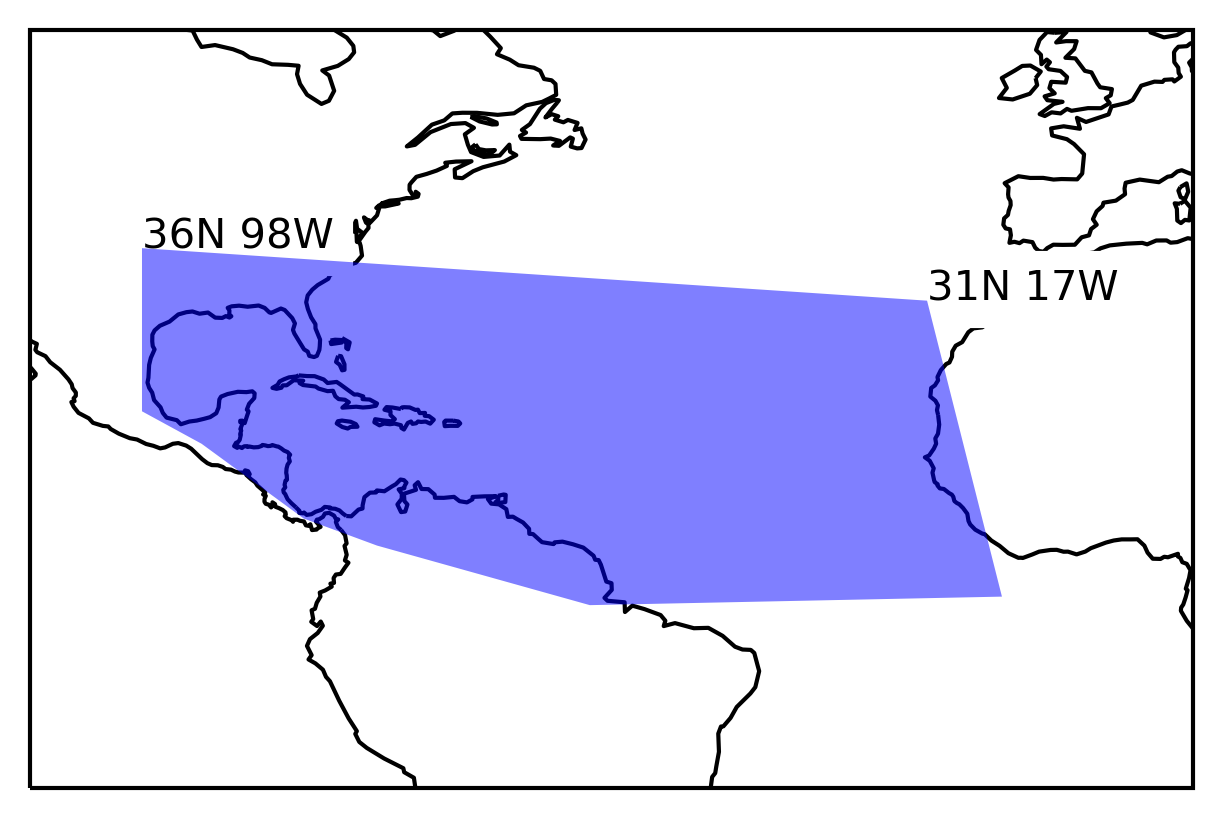

In [16]:
plt.close('all')
fig,ax = plt.subplots(nrows=1, figsize=(5,5), subplot_kw={'projection':ccrs.PlateCarree()}, dpi=300)
ax.coastlines()
ax.set_extent([-110,10,-10,40])
ax.add_geometries([Polygon([[-98.44,19.48],[-92.29,16.13],[-81.74,8.41],[-74.18,5.62],[-52.21,-0.53],[-9.67,0.35],[-17.4,30.9],[-98.44,36.32],[-98.44,32.25],[-98.44,19.48]])], ccrs.PlateCarree(),alpha=0.5,facecolor=details['color'],linewidth=3,zorder=100)
for pt in [[-17.4,30.9],[-98.44,36.32]]:
    x,y = pt
    ax.annotate('%sN %sW' %(round(y),round(-x)), xy=(x,y), xycoords=ccrs.PlateCarree()._as_mpl_transform(ax), backgroundcolor='w')
# plt.tight_layout()
plt.savefig('tracks/tracks_considered.pdf')